In [1]:
import mxnet as mx
from mxnet import init, gluon, nd, autograd, image
from mxnet.gluon import nn, Block, HybridBlock
from mxnet.gluon.model_zoo import vision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
%matplotlib inline
mpl.rcParams['figure.dpi']= 120
ctx = mx.gpu()
data_dir = '/home/sinyer/python/data/pikachu'

In [2]:
def load_data(batch_size, data_route = data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/')
    data_dir = data_route+'/'
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
              'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
              'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)
    
    train_iter = image.ImageDetIter(
        batch_size = batch_size, data_shape = (3, 256, 256),
        path_imgrec = data_dir+'train.rec', path_imgidx = data_dir+'train.idx',
        shuffle = True, mean = True, rand_crop = 1,
        min_object_covered = 0.95, max_attempts = 200)
    val_iter = image.ImageDetIter(
        batch_size = batch_size, data_shape = (3, 256, 256),
        path_imgrec=data_dir+'val.rec', shuffle=False, mean=True)
    return train_iter, val_iter

In [3]:
batch_size = 32
class_names = ['pikachu']
num_class = len(class_names)

train_data, test_data = load_data(batch_size)

In [4]:
def box_to_rect(box, color, linewidth=3):
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

def transform_center(xy):
    b, h, w, n, s = xy.shape
    offset_y = nd.tile(nd.arange(0, h, repeat=(w * n * 1), 
                                 ctx=xy.context).reshape((1, h, w, n, 1)), (b, 1, 1, 1, 1))
    offset_x = nd.tile(nd.arange(0, w, repeat=(n * 1), 
                                 ctx=xy.context).reshape((1, 1, w, n, 1)), (b, h, 1, 1, 1))
    x, y = xy.split(num_outputs=2, axis=-1)
    x = (x + offset_x) / w
    y = (y + offset_y) / h
    return x, y

def transform_size(wh, anchors):
    b, h, w, n, s = wh.shape
    aw, ah = nd.tile(nd.array(anchors, ctx=wh.context).reshape((1, 1, 1, -1, 2)), 
                     (b, h, w, 1, 1)).split(num_outputs=2, axis=-1)
    w_pred, h_pred = nd.exp(wh).split(num_outputs=2, axis=-1)
    w_out = w_pred * aw / w
    h_out = h_pred * ah / h
    return w_out, h_out

def yolo2_forward(x, num_class, anchor_scales):
    stride = num_class + 5
    x = x.transpose((0, 2, 3, 1))
    x = x.reshape((0, 0, 0, -1, stride))
    cls_pred = x.slice_axis(begin=0, end=num_class, axis=-1)
    score_pred = x.slice_axis(begin=num_class, end=num_class + 1, axis=-1)
    score = nd.sigmoid(score_pred)
    xy_pred = x.slice_axis(begin=num_class + 1, end=num_class + 3, axis=-1)
    xy = nd.sigmoid(xy_pred)
    wh = x.slice_axis(begin=num_class + 3, end=num_class + 5, axis=-1)
    x, y = transform_center(xy)
    w, h = transform_size(wh, anchor_scales)
    cid = nd.argmax(cls_pred, axis=-1, keepdims=True)
    half_w = w / 2
    half_h = h / 2
    left = nd.clip(x - half_w, 0, 1)
    top = nd.clip(y - half_h, 0, 1)
    right = nd.clip(x + half_w, 0, 1)
    bottom = nd.clip(y + half_h, 0, 1)
    output = nd.concat(*[cid, score, left, top, right, bottom], dim=4)
    return output, cls_pred, score, nd.concat(*[xy, wh], dim=4)

def corner2center(boxes, concat=True):
    left, top, right, bottom = boxes.split(axis=-1, num_outputs=4)
    x = (left + right) / 2
    y = (top + bottom) / 2
    width = right - left
    height = bottom - top
    if concat:
        last_dim = len(x.shape) - 1
        return nd.concat(*[x, y, width, height], dim=last_dim)
    return x, y, width, height

def center2corner(boxes, concat=True):
    x, y, w, h = boxes.split(axis=-1, num_outputs=4)
    w2 = w / 2
    h2 = h / 2
    left = x - w2
    top = y - h2
    right = x + w2
    bottom = y + h2
    if concat:
        last_dim = len(left.shape) - 1
        return nd.concat(*[left, top, right, bottom], dim=last_dim)
    return left, top, right, bottom

def yolo2_target(scores, boxes, labels, anchors, ignore_label=-1, thresh=0.5):
    b, h, w, n, _ = scores.shape
    anchors = np.reshape(np.array(anchors), (-1, 2))
    gt_boxes = nd.slice_axis(labels, begin=1, end=5, axis=-1)
    target_score = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    target_id = nd.ones_like(target_score, ctx=scores.context) * ignore_label
    target_box = nd.zeros((b, h, w, n, 4), ctx=scores.context)
    sample_weight = nd.zeros((b, h, w, n, 1), ctx=scores.context)
    for b in range(output.shape[0]):
        label = labels[b].asnumpy()
        valid_label = label[np.where(label[:, 0] > -0.5)[0], :]
        np.random.shuffle(valid_label)
        for l in valid_label:
            gx, gy, gw, gh = (l[1] + l[3]) / 2, (l[2] + l[4]) / 2, l[3] - l[1], l[4] - l[2]
            ind_x = int(gx * w)
            ind_y = int(gy * h)
            tx = gx * w - ind_x
            ty = gy * h - ind_y
            gw = gw * w
            gh = gh * h
            intersect = np.minimum(anchors[:, 0], gw) * np.minimum(anchors[:, 1], gh)
            ovps = intersect / (gw * gh + anchors[:, 0] * anchors[:, 1] - intersect)
            best_match = int(np.argmax(ovps))
            target_id[b, ind_y, ind_x, best_match, :] = l[0]
            target_score[b, ind_y, ind_x, best_match, :] = 1.0
            tw = np.log(gw / anchors[best_match, 0])
            th = np.log(gh / anchors[best_match, 1])
            target_box[b, ind_y, ind_x, best_match, :] = mx.nd.array([tx, ty, tw, th])
            sample_weight[b, ind_y, ind_x, best_match, :] = 1.0
    return target_id, target_score, target_box, sample_weight

In [5]:
class YOLO2Output(HybridBlock):
    def __init__(self, num_class, anchor_scales, **kwargs):
        super(YOLO2Output, self).__init__(**kwargs)
        assert num_class > 0, "number of classes should > 0, given {}".format(num_class)
        self._num_class = num_class
        assert isinstance(anchor_scales, (list, tuple)), "list or tuple of anchor scales required"
        assert len(anchor_scales) > 0, "at least one anchor scale required"
        for anchor in anchor_scales:
            assert len(anchor) == 2, "expected each anchor scale to be (width, height), provided {}".format(anchor)
        self._anchor_scales = anchor_scales
        out_channels = len(anchor_scales) * (num_class + 1 + 4)
        with self.name_scope():
            self.output = nn.Conv2D(out_channels, 1, 1)
    def hybrid_forward(self, F, x, *args):
        return self.output(x)

In [6]:
data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])
rgb_std = nd.array([58.395, 57.12, 57.375])

positive_weight = 5.0
negative_weight = 0.1
class_weight = 1.0
box_weight = 5.0

pretrained = vision.get_model('resnet18_v1', pretrained=True).features
net = nn.HybridSequential()
for i in range(len(pretrained) - 2):
    net.add(pretrained[i])

scales = [[3.3004, 3.59034], [9.84923, 8.23783]]

predictor = YOLO2Output(2, scales)
predictor.initialize()
net.add(predictor)

net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 1, 'wd': 5e-4})

sce_loss = gluon.loss.SoftmaxCrossEntropyLoss(from_logits=False)
l1_loss = gluon.loss.L1Loss()

In [7]:
for epoch in range(50):
    start = time()
    train_data.reset()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            x = net(x)
            output, cls_pred, score, xywh = yolo2_forward(x, 2, scales)
            with autograd.pause():
                tid, tscore, tbox, sample_weight = yolo2_target(
                    score, xywh, y, scales, thresh=0.5)
            loss1 = sce_loss(cls_pred, tid, sample_weight * class_weight)
            score_weight = nd.where(sample_weight > 0, 
                                    nd.ones_like(sample_weight) * positive_weight, 
                                    nd.ones_like(sample_weight) * negative_weight)
            loss2 = l1_loss(score, tscore, score_weight)
            loss3 = l1_loss(xywh, tbox, sample_weight * box_weight)
            loss = loss1 + loss2 + loss3
        loss.backward()
        trainer.step(batch_size)
    
    print('%d, loss:%.5f, time:%.3f' % (epoch, nd.mean(loss).asscalar(), time()-start))

0, loss:0.02319, time:7.962
1, loss:0.01138, time:6.957
2, loss:0.00662, time:6.674
3, loss:0.00443, time:6.717
4, loss:0.00319, time:6.669
5, loss:0.00271, time:6.738
6, loss:0.00234, time:6.719
7, loss:0.00202, time:6.669
8, loss:0.00186, time:6.690
9, loss:0.00213, time:6.715
10, loss:0.00191, time:6.740
11, loss:0.00165, time:6.664
12, loss:0.00140, time:6.718
13, loss:0.00124, time:6.690
14, loss:0.00125, time:6.708
15, loss:0.00149, time:6.720
16, loss:0.00114, time:6.682
17, loss:0.00109, time:6.647
18, loss:0.00106, time:6.698
19, loss:0.00107, time:6.683
20, loss:0.00102, time:6.698
21, loss:0.00095, time:6.682
22, loss:0.00102, time:6.687
23, loss:0.00099, time:6.712
24, loss:0.00094, time:6.701
25, loss:0.00140, time:6.721
26, loss:0.00091, time:6.678
27, loss:0.00094, time:6.733
28, loss:0.00094, time:6.728
29, loss:0.00086, time:6.692
30, loss:0.00097, time:6.721
31, loss:0.00125, time:6.728
32, loss:0.00082, time:6.727
33, loss:0.00094, time:6.671
34, loss:0.00089, time:6

In [8]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    data = image.imresize(im, data_shape, data_shape)
    data = (data.astype('float32') - rgb_mean) / rgb_std
    return data.transpose((2,0,1)).expand_dims(axis=0), im

def predict(x):
    x = net(x)
    output, cls_prob, score, xywh = yolo2_forward(x, 2, scales)
    return nd.contrib.box_nms(output.reshape((0, -1, 6)))

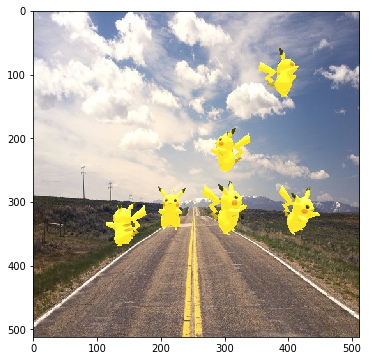

In [9]:
x, im = process_image('pikachu.jpg')
out = predict(x.as_in_context(ctx))

mpl.rcParams['figure.figsize'] = (6,6)
colors = ['blue', 'green', 'red', 'black', 'magenta']

def display(im, out, threshold=0.5):    
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)
        text = class_names[class_id]
        plt.gca().text(box[0], box[1], 
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.2)